In [1]:
import jax
import gpjax

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-25 12:11:55.520601: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [11]:
# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

key = jr.key(123)
mpl.rcParams.update(mpl.rcParamsDefault)
#plt.style.use(
##    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
#)
#cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [12]:
n = 100
noise = 0.3

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

In [13]:
fig, ax = plt.subplots()
ax.plot(x, y)#, "o", label="Observations", color=cols[0])
ax.plot(xtest, ytest)#, label="Latent function", color=cols[1])
#ax.legend(loc="best")

In [15]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

In [16]:

prior_dist = prior.predict(xtest)

prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(20,))


fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, color=cols[0], label="Prior samples")
ax.plot(xtest, prior_mean, color=cols[1], label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    color=cols[1],
    label="Prior variance",
)
# ax.legend(loc="best")

In [17]:
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=D)

Array(124.80517341, dtype=float64)

In [18]:
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=D,
)

Optimization terminated successfully.
         Current function value: 55.103686
         Iterations: 16
         Function evaluations: 19
         Gradient evaluations: 19


In [19]:
opt_posterior, history = gpx.fit(
    model=posterior,
    objective=negative_mll,
    train_data=D,
    optim=ox.adam(learning_rate=0.01),
    num_iters=500,
    safe=True,
    key=key,
)

Compiling...:   0%|                                                                                                                           | 0/500 [00:00<?, ?it/s]

NotImplementedError: host_callback functionality isn't supported with PJRT C API. See https://jax.readthedocs.io/en/latest/debugging/index.html and https://jax.readthedocs.io/en/latest/notebooks/external_callbacks.html for alternatives. Please file a feature request at https://github.com/google/jax/issues if none of the alternatives are sufficient.

In [43]:

@jit
def predict(params, posterior):
    latent_dist = posterior.predict(xtest, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()
    return predictive_mean+jnp.sum(params), predictive_std
params = jnp.array([1,2,3])
predictive_mean, predictive_std = predict(params, opt_posterior)
predict_grad = jax.grad(predict, argnums=(0))
predict_grad(opt_posterior)

In [44]:
# latent_dist = opt_posterior.predict(xtest, train_data=D)
# predictive_dist = opt_posterior.likelihood(latent_dist)

# predictive_mean = predictive_dist.mean()
# predictive_std = predictive_dist.stddev()

In [45]:
opt_posterior

ConjugatePosterior(prior=Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(0.45539489, dtype=float64), variance=Array(1.26104256, dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06), likelihood=Gaussian(num_datapoints=100, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.31996358, dtype=float64)), jitter=1e-06)

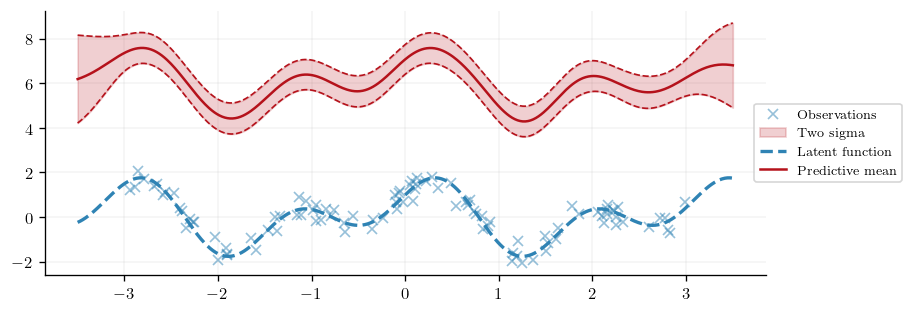

In [46]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))